In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [5]:
data=pd.read_csv("data.csv",
                 usecols=['Date', 'open', 'high', 'low', 'close', 'vol'],
                 parse_dates=['Date'],
                 index_col=['Date'],)
data.head(10)

,open,high,low,close,vol
Date,,,,,
2012-01-01,873.0,879.0,851.0,879.0,799
2012-01-02,879.0,913.0,882.0,900.0,1002
2012-01-03,900.0,916.0,892.0,892.0,2653
2012-01-04,892.0,875.0,842.0,865.0,490
2012-01-05,865.0,875.0,858.0,858.0,121
2012-01-08,858.0,845.0,814.0,830.0,4835
2012-01-09,830.0,846.0,830.0,846.0,195
2012-01-10,858.0,862.0,845.0,845.0,658
2012-01-11,845.0,874.0,845.0,874.0,969


In [6]:
data.isnull().sum() #checking for nullity

open     0
high     0
low      0
close    0
vol      0
dtype: int64

In [7]:
def plot_graph(record):      # reusale function for plotting purposes
    plt.figure(figsize=(20,12))
    plt.plot(record)

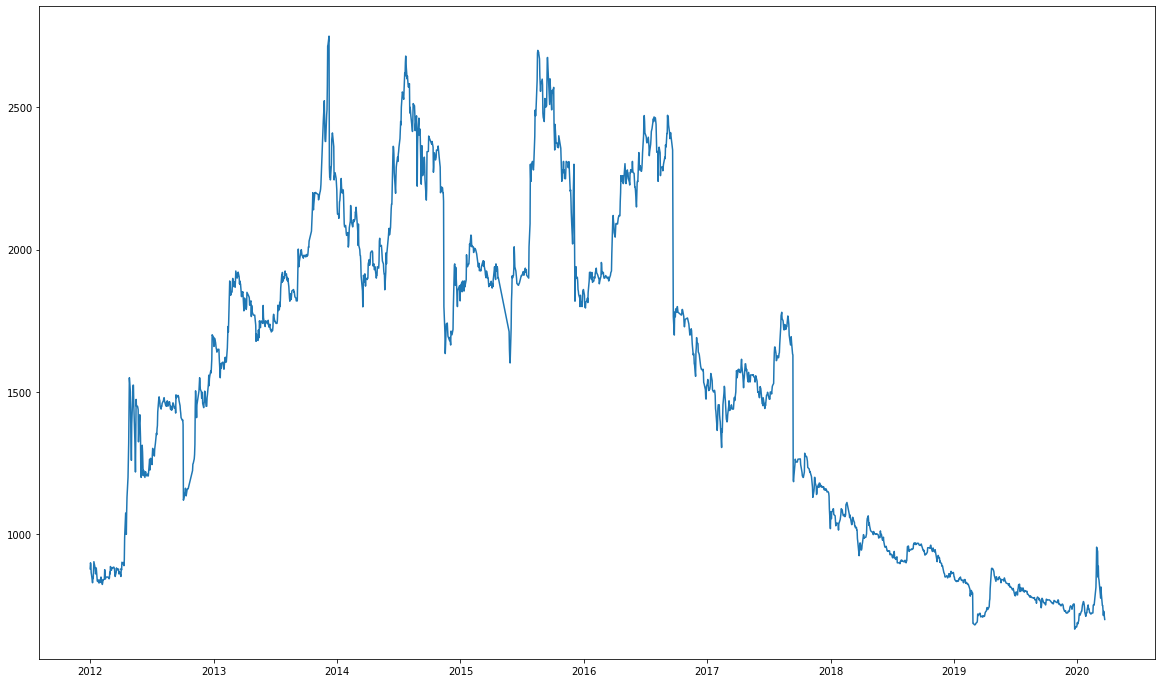

In [8]:
plot_graph(data.close)

In [9]:
data=data[['close']]
data.tail()

,close
Date,
2020-03-16,750.0
2020-03-17,731.0
2020-03-18,715.0
2020-03-19,730.0
2020-03-22,701.0


In [11]:
data.close=data.close.resample("W").mean()  #smoothing the data by resampling it in week period
data.dropna(inplace=True)
data.head(10)

,close
Date,
2012-01-01,879.000000
2012-01-08,869.000000
2012-01-22,864.500000
2012-01-29,833.750000
2012-02-05,838.250000
2012-02-12,835.600000
2012-02-26,848.000000
2012-03-04,867.200000
2012-03-11,883.333333


### The curve is smoother than the previous one

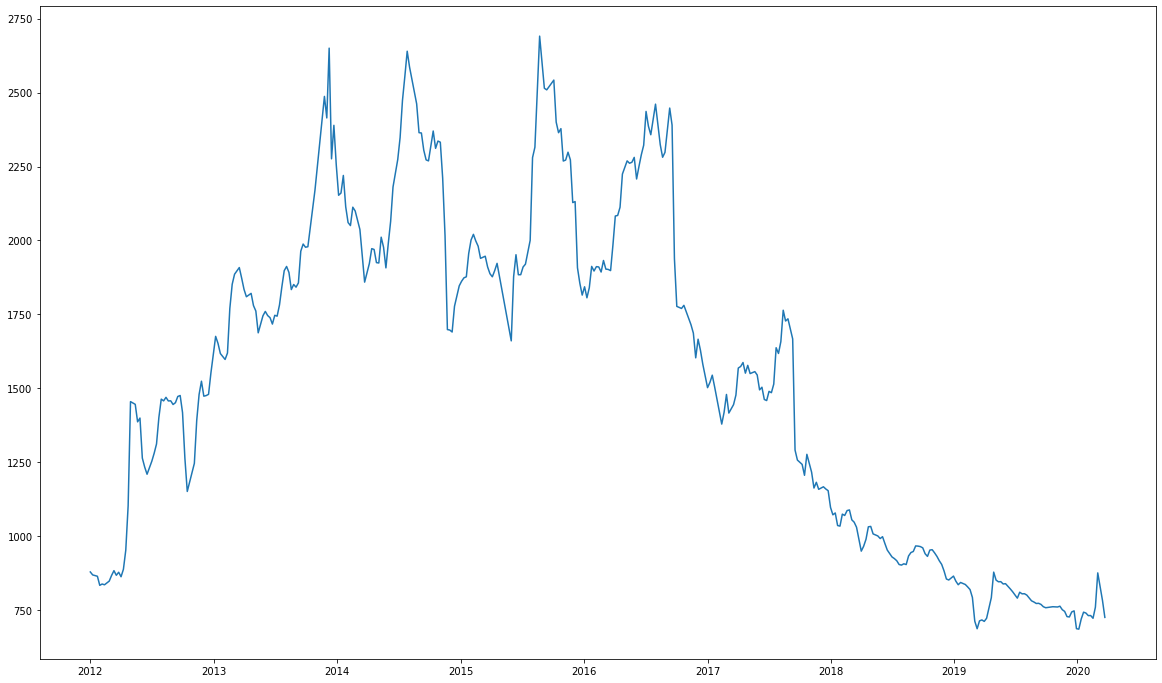

In [13]:
plot_graph(data.close) 

## Cheking for stationarity of time series

In [15]:
from statsmodels.tsa.stattools import adfuller

#Ho: It is not stationary
#H1: It is stationary

def adfuller_test(records):
    result=adfuller(records)
    labels=['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for label,value in zip(labels,result):
        print(label+" : "+str(value))
    if result[1]<=0.05:
        print("Null hypothesis is rejected. Series is stationary.")
    else:
        print("Null hypothesis is accepted. Series in not stationary.")

In [16]:
adfuller_test(data.close)

ADF Test Statistic : -1.5935367271274512
p-value : 0.48683941293703936
#Lags Used : 2
Number of Observations Used : 376
Null hypothesis is accepted. Series in not stationary.


In [52]:
first_difference=pd.DataFrame(data['close']-data['close'].shift(1))
first_difference

,close
Date,
2012-01-01,NaN
2012-01-08,-10.00
2012-01-22,-4.50
2012-01-29,-30.75
2012-02-05,4.50
...,...
2020-02-16,-9.20
2020-02-23,37.40
2020-03-01,116.00


In [53]:
adfuller_test(first_difference.dropna())

ADF Test Statistic : -11.510902375472899
p-value : 4.262368018383259e-21
#Lags Used : 1
Number of Observations Used : 376
Null hypothesis is rejected. Series is stationary.


In [58]:
first_difference=first_difference.dropna()
first_difference['ds']=first_difference.index
first_difference.reset_index(drop=True, inplace=True)
first_difference

,close,ds
0,-10.00,2012-01-08
1,-4.50,2012-01-22
2,-30.75,2012-01-29
3,4.50,2012-02-05
4,-2.65,2012-02-12
...,...,...
373,-9.20,2020-02-16
374,37.40,2020-02-23
375,116.00,2020-03-01
376,-93.05,2020-03-15


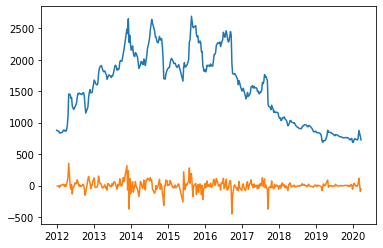

In [59]:
data['ds']=data.index
data.reset_index(drop=True)

plt.plot(data.set_index('ds'))
plt.plot(first_difference.set_index('ds'))

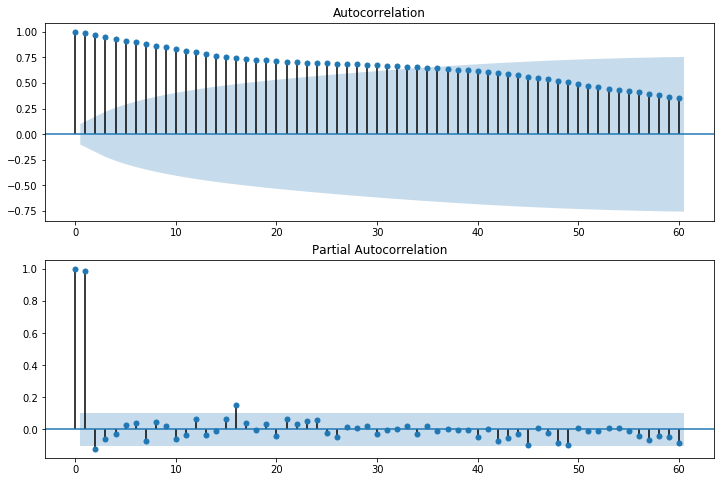

In [62]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(data['close'].dropna(),lags=60,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(data['close'].dropna(),lags=60,ax=ax2)

In [69]:
from statsmodels.tsa.arima.model import ARIMA

model=ARIMA(data['close'],order=(10,1,0))
model_fit=model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  379
Model:                ARIMA(10, 1, 0)   Log Likelihood               -2164.972
Date:                Thu, 26 Aug 2021   AIC                           4351.943
Time:                        10:52:38   BIC                           4395.227
Sample:                             0   HQIC                          4369.122
                                - 379                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1479      0.036      4.153      0.000       0.078       0.218
ar.L2          0.1040      0.045      2.334      0.020       0.017       0.191
ar.L3         -0.0455      0.043     -1.047      0.2

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


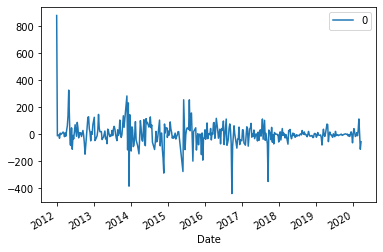

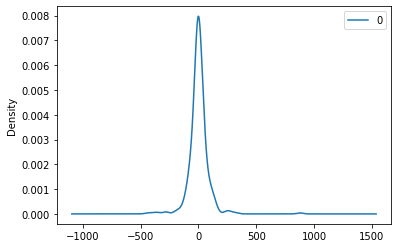

In [70]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')

In [72]:
residuals.describe()

,0
count,379.000000
mean,1.921244
std,86.961708
min,-437.907036
25%,-25.279869
50%,-1.340011
75%,30.580257
max,879.000000


In [112]:
X=data.close.values
len(X)

379

In [113]:
size = int(len(X) * 0.66)  #splitting of data into train and test set
train, test = X[0:size], X[size:len(X)]
actual_train = [x for x in train]
predictions=[]

In [114]:
for t in range(len(test)):
    model = ARIMA(actual_train, order=(10,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    prediction = output[0]
    predictions.append(prediction)
    test_value = test[t]
    actual_train.append(test_value)
    print('%d. predicted=%f, expected=%f'%(t+1,prediction,test_value))

1. predicted=1521.460541, expected=1637.200000
2. predicted=1656.307342, expected=1617.800000
3. predicted=1623.617855, expected=1658.000000
4. predicted=1657.938763, expected=1764.000000
5. predicted=1775.936655, expected=1727.500000
6. predicted=1726.304317, expected=1735.000000
7. predicted=1738.583652, expected=1667.000000
8. predicted=1645.511737, expected=1291.200000
9. predicted=1220.230892, expected=1257.333333
10. predicted=1231.974624, expected=1242.666667
11. predicted=1245.881067, expected=1205.800000
12. predicted=1224.085372, expected=1276.750000
13. predicted=1309.133068, expected=1246.750000
14. predicted=1216.913047, expected=1216.400000
15. predicted=1237.892378, expected=1162.800000
16. predicted=1167.590705, expected=1182.200000
17. predicted=1153.303735, expected=1158.400000
18. predicted=1167.751218, expected=1167.000000
19. predicted=1162.386978, expected=1159.600000
20. predicted=1154.018552, expected=1153.800000
21. predicted=1154.046824, expected=1097.250000
2

In [147]:
from sklearn.metrics import mean_squared_error
import math

error=mean_squared_error(test,predictions)
rmse=math.sqrt(error)
print(f'The mean squared error is {error}')
print(f'The rmse is {rmse}')

The mean squared error is 2032.826796788743
The rmse is 45.086880539562095


In [148]:
rng=data.iloc[250:,:].index
pred=pd.DataFrame(data=predictions,index=rng, columns=['prediction'])
pred['ds']=pred.index
pred.reset_index(drop=True, inplace=True)

pred

,prediction,ds
0,1521.460541,2017-07-23
1,1656.307342,2017-07-30
2,1623.617855,2017-08-06
3,1657.938763,2017-08-13
4,1775.936655,2017-08-20
...,...,...
124,732.676398,2020-02-16
125,727.679263,2020-02-23
126,761.542599,2020-03-01
127,893.719182,2020-03-15


## The model worked well in test data

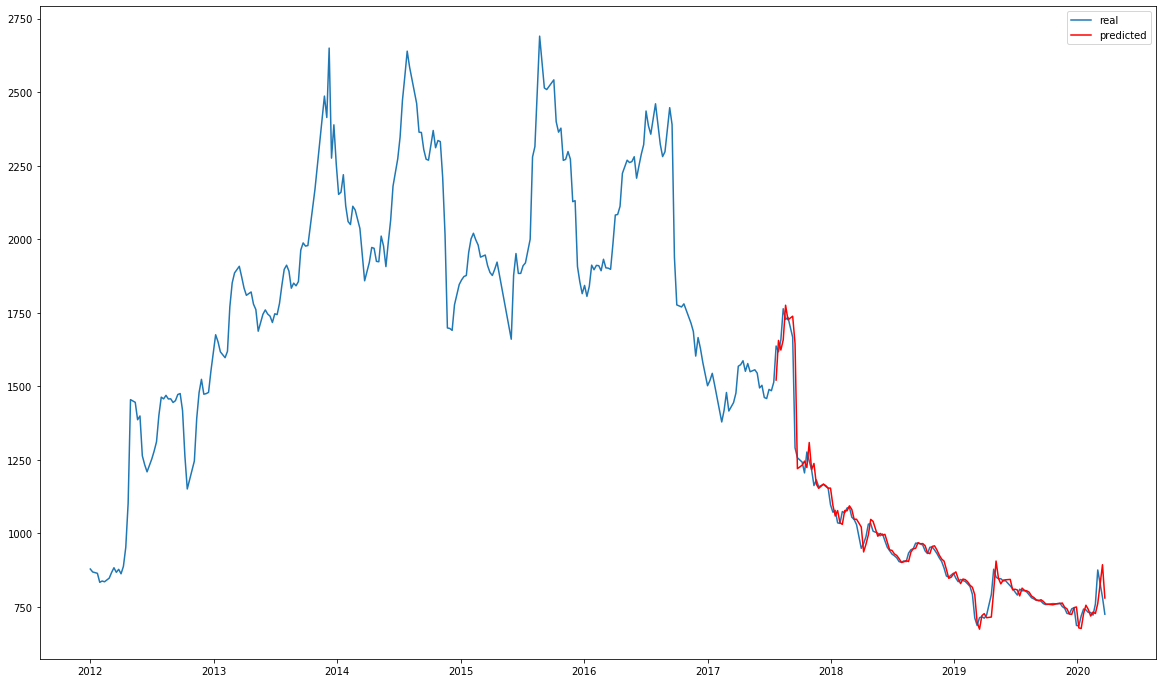

In [149]:
plt.figure(figsize=(20,12))
plt.plot(data.set_index('ds'),label="real")
plt.plot(pred.set_index('ds'),color='r',label='predicted')
plt.legend()

## Forecasting closing price for next 20 weeks.
It is to be kept in mind that as we keep moving in forecasting period(towards the end of 20 weeks period), the       uncertainity in the prediction increases.

I have implemented 2 methods of forecasting:<br/>
* using forecast() function of ARIMA. <br/>
* training ARIMA again for next 20 weeks, appending the predicted value in training list.

### Method 1-Not recommended

In [164]:
forecast_20=model_fit.forecast(steps=20)


In [165]:
rng_20=pd.date_range(start="2020-03-23",periods=20, freq='W')
len(rng_20)

20

In [166]:
rng_20

DatetimeIndex(['2020-03-29', '2020-04-05', '2020-04-12', '2020-04-19',
               '2020-04-26', '2020-05-03', '2020-05-10', '2020-05-17',
               '2020-05-24', '2020-05-31', '2020-06-07', '2020-06-14',
               '2020-06-21', '2020-06-28', '2020-07-05', '2020-07-12',
               '2020-07-19', '2020-07-26', '2020-08-02', '2020-08-09'],
              dtype='datetime64[ns]', freq='W-SUN')

In [167]:
forecast=pd.DataFrame(data=forecast_20[0],index=rng_20,columns=['forecast'])
forecast

,forecast
2020-03-29,780.520141
2020-04-05,780.520141
2020-04-12,780.520141
2020-04-19,780.520141
2020-04-26,780.520141
2020-05-03,780.520141
2020-05-10,780.520141
2020-05-17,780.520141
2020-05-24,780.520141
2020-05-31,780.520141


In [168]:
from tqdm import tqdm

## Method 2

In [169]:
forecasts=list()
forecast_train=actual_train.copy()
for t in tqdm(range(20)):
    
    model2 = ARIMA(forecast_train, order=(10,1,0))
    model_fit2 = model2.fit()
    output = model_fit2.forecast()
    
    forecast = output[0]
    forecasts.append(forecast)
    forecast_train.append(forecast)

100%|██████████| 20/20 [00:03<00:00,  5.46it/s]


In [170]:
sample_forecasted=pd.DataFrame(data=forecasts,index=rng_20,columns=['forecast'])
sample_forecasted

,forecast
2020-03-29,702.793407
2020-04-05,688.776733
2020-04-12,691.041701
2020-04-19,708.788955
2020-04-26,696.194403
2020-05-03,693.692481
2020-05-10,705.514875
2020-05-17,706.088963
2020-05-24,705.191168
2020-05-31,705.658818


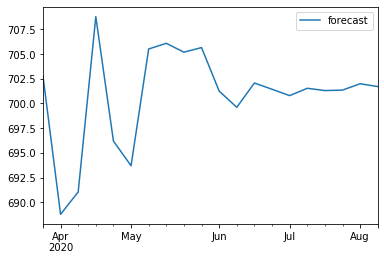

In [171]:
sample_forecasted.plot()

In [175]:
forecasts

[702.7934067807618,
 688.776732714521,
 691.0417011370583,
 708.7889545581816,
 696.1944033892813,
 693.6924809469609,
 705.5148745823349,
 706.0889634891685,
 705.1911679369251,
 705.6588177007992,
 701.2519899516864,
 699.6113811105337,
 702.0702206107147,
 701.4385707348899,
 700.7925057668335,
 701.5360721409104,
 701.305162125968,
 701.3531533925147,
 701.9963391394004,
 701.70967591292]

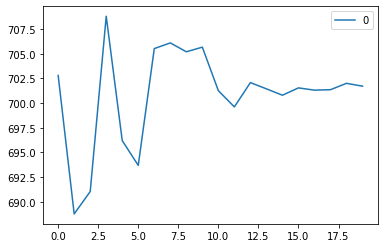

In [176]:
pd.DataFrame(forecasts).plot()

### The 2nd method seems to be working well. So code in kernels below uses the prediction from this method.
I have spliced the dataframe to get recent data(>=2019) and concatenated it with predicted value. If concatenation is not to done, there occurs discontinuity in the graph. This is because two different dataframes are plotted, terminating value of 1st and initiating value of 2nd dataframe doesn't coincide at a point resulting in discontinuity.

In [179]:
recent_data=data["2019":].copy()
recent_data.head()

,close,ds
Date,,
2019-01-06,847.8,2019-01-06
2019-01-13,835.8,2019-01-13
2019-01-20,843.4,2019-01-20
2019-01-27,840.2,2019-01-27
2019-02-03,836.6,2019-02-03


In [180]:
recent_data.columns=['forecast', 'ds']
recent_data.head()

,forecast,ds
Date,,
2019-01-06,847.8,2019-01-06
2019-01-13,835.8,2019-01-13
2019-01-20,843.4,2019-01-20
2019-01-27,840.2,2019-01-27
2019-02-03,836.6,2019-02-03


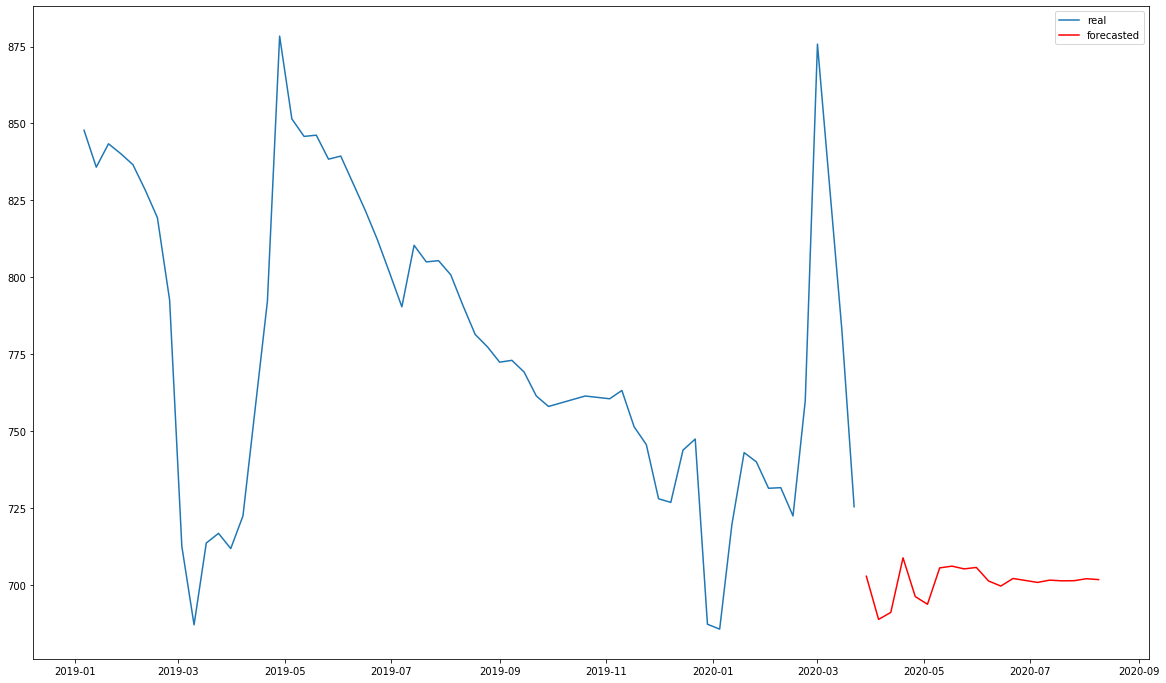

In [185]:
plt.figure(figsize=(20,12))
plt.plot(recent_data.set_index('ds'),label="real")
plt.plot(sample_forecasted,color='red',label='forecasted')
plt.legend()

## Discontinuous Graph

In [197]:
sample_forecasted['ds']=sample_forecasted.index
sample_forecasted=sample_forecasted.reset_index(drop=True)


In [198]:
collective_data=pd.concat([recent_data,sample_forecasted])
collective_data.tail()


,forecast,ds
15,701.536072,2020-07-12
16,701.305162,2020-07-19
17,701.353153,2020-07-26
18,701.996339,2020-08-02
19,701.709676,2020-08-09


Text(2020-03-29 00:00:00, 720, 'Forecast begins here')

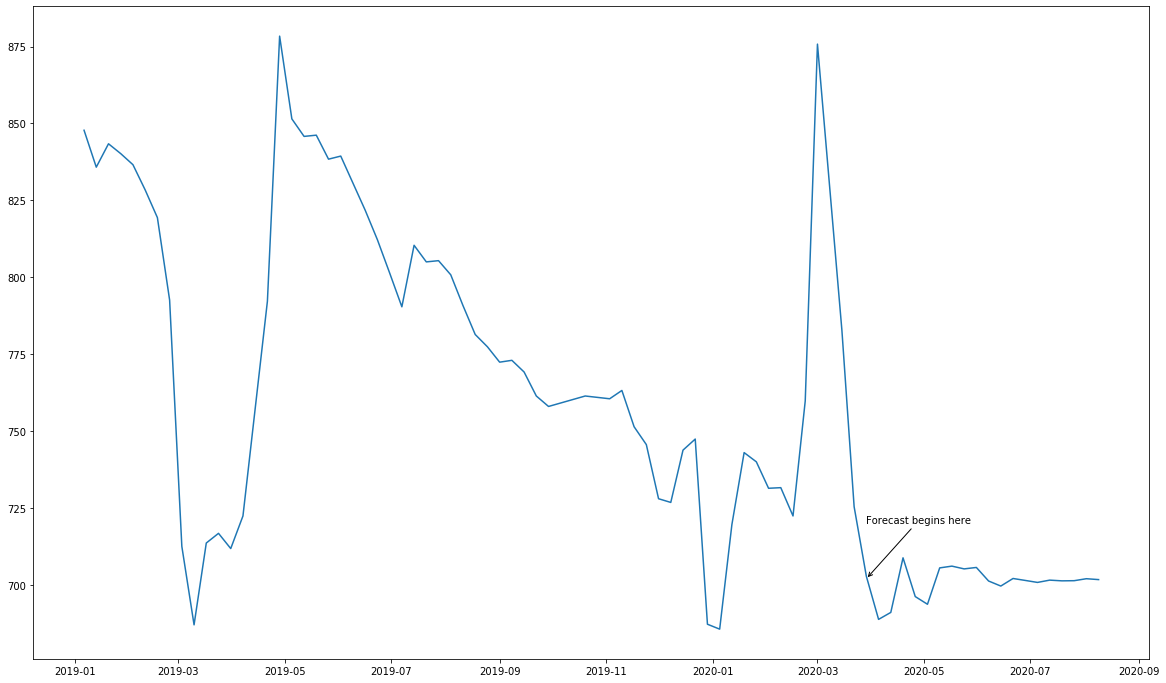

In [194]:
from datetime import datetime
plt.figure(figsize=(20,12))
plt.plot(collective_data.set_index('ds'))
plt.annotate("Forecast begins here",
             xy= (datetime(2020,3,29), 702),
             arrowprops=dict(arrowstyle="->"),
             xytext=(datetime(2020,3,29), 720))